In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import pickle

sys.path.append("../../src")
from explainer import Archipelago
from application_utils.image_utils import *
from application_utils.utils_torch import ModelWrapperTorch

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = torch.device("cuda:0")

In [ ]:
explanation_outline_thickness = 1

## Get Model

In [2]:
model = models.resnet152(pretrained=True).to(device).eval();
model_wrapper = ModelWrapperTorch(model, device)

## Get Images

In [3]:
base_path = "/meladyfs/newyork/datasets/imagenet14/test"
test_data = sorted(
    [base_path + "/" + f for f in os.listdir(base_path) if f.endswith(".JPEG")]
)

target_count = 100

np.random.seed(42)
indexes = np.random.choice(len(test_data), target_count, replace=False)

In [4]:
skip_imgs = [19864, 76699, 76434, 84004, 16638, 42141, 64883, 79022, 84936] #these images have humans in them

## Get Example

  0%|          | 0/21 [00:00<?, ?it/s]

classification: Great Dane


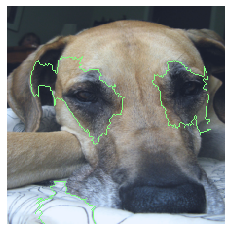

  5%|▍         | 1/21 [00:24<08:14, 24.74s/it]

classification: spider monkey, Ateles geoffroyi


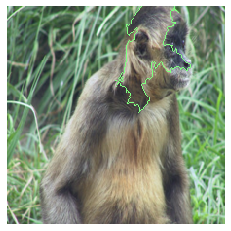

 10%|▉         | 2/21 [00:50<07:56, 25.08s/it]

classification: obelisk


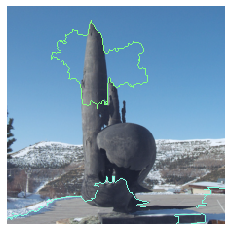

 24%|██▍       | 5/21 [01:11<05:14, 19.69s/it]

classification: snow leopard, ounce, Panthera uncia


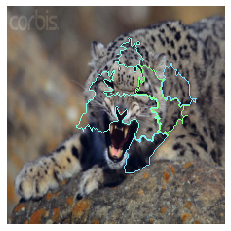

 38%|███▊      | 8/21 [01:43<03:40, 16.98s/it]

classification: apron


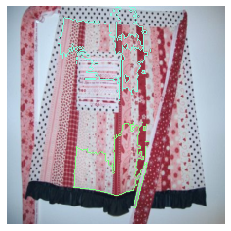

 43%|████▎     | 9/21 [02:12<04:06, 20.53s/it]

classification: black stork, Ciconia nigra


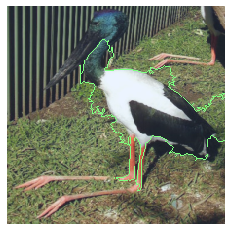

 48%|████▊     | 10/21 [02:39<04:05, 22.28s/it]

classification: waffle iron


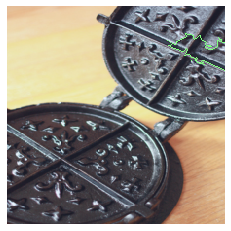

 52%|█████▏    | 11/21 [03:05<03:56, 23.64s/it]

classification: snow leopard, ounce, Panthera uncia


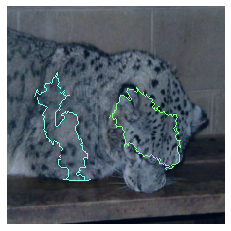

 62%|██████▏   | 13/21 [03:34<02:46, 20.85s/it]

classification: Polaroid camera, Polaroid Land camera


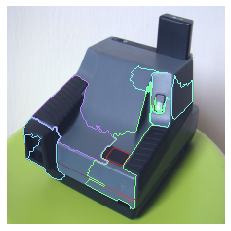

 71%|███████▏  | 15/21 [03:53<01:44, 17.41s/it]

classification: Greater Swiss Mountain dog


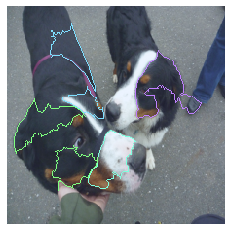

 76%|███████▌  | 16/21 [04:20<01:41, 20.25s/it]

classification: dam, dike, dyke


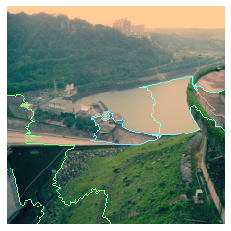

 81%|████████  | 17/21 [04:39<01:20, 20.05s/it]

classification: sea urchin


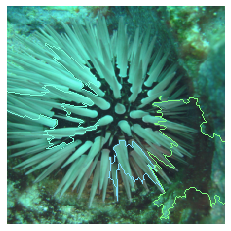

 86%|████████▌ | 18/21 [05:06<01:06, 22.05s/it]

classification: Tibetan terrier, chrysanthemum dog


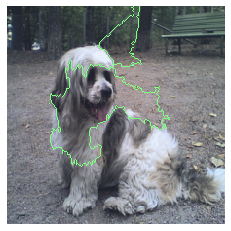

 90%|█████████ | 19/21 [05:32<00:46, 23.10s/it]

classification: Saluki, gazelle hound


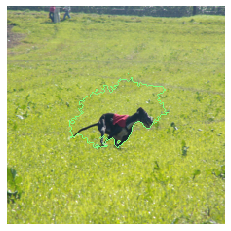

100%|██████████| 21/21 [06:01<00:00, 17.20s/it]


In [5]:
top_k = 5

results = []
for index in tqdm(indexes[:12+len(skip_imgs)]):    
    if index in skip_imgs: continue

    image_path = test_data[index]
    img_filename = image_path.split("/")[-1]
    image, labels = get_image_and_labels(image_path, device)
    
    predictions = model_wrapper(np.expand_dims(image,0))
    class_idx = predictions[0].argsort()[::-1][0]
    print("classification:",labels[class_idx])
    
    baseline = np.zeros_like(image)
    segments = quickshift(image, kernel_size=3, max_dist=300, ratio=0.2)

    xf = ImageXformer(image, baseline, segments)
    apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)
    explanation = apgo.explain(top_k=top_k)
    exp, num_pos_interactions = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)
    
    if num_pos_interactions == 0:
        continue
    
    plt.imshow(exp/2+0.5)
    plt.axis("off")
    plt.show()
    
    results.append( {"image":exp, "prediction": labels[class_idx]} )
    
#     with open('results/exp_figs_4-21_k5_nohuman_thin.pickle', 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
